In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
# makes random splits in dataset, labels for train and valid sets
# Example: X_train, y_train, X_valid, y_valid = train_valid_split(train_images.values, train_labels.values, 0.8, 0.2)
def train_valid_split(dataset, labels, train_split, valid_split):
    if (train_split + valid_split) != 1:
        raise ValueError("invalid size for train_split, valid_split")
    num_rows = dataset.shape[0]
    num_cols = dataset.shape[1]
    train = list()
    valid = list()
    dataset_copy = list(dataset)
    
    y_train = list()
    y_valid = list()
    labels_copy = list(labels)
    
    train_size = train_split*num_rows
    valid_size = valid_split*num_rows
    
    while len(train) < train_size:
        index = random.randrange(len(dataset_copy))
        train.append(dataset_copy.pop(index))
        y_train.append(labels_copy.pop(index))
    
    while len(valid) < valid_size:
        index = random.randrange(len(dataset_copy))
        valid.append(dataset_copy.pop(index))
        y_valid.append(labels_copy.pop(index))
        
    return pd.DataFrame(np.array(train)), pd.DataFrame(np.array(y_train)),pd.DataFrame(np.array(valid)),pd.DataFrame(np.array(y_valid))
     
    

In [3]:
def standardize(data):
    new_data = np.zeros((data.shape[0],data.shape[1]))
    for i in range(data.shape[1]):
        a_col = data[:,i]
        col_mean = np.mean(a_col)
        col_std = np.std(a_col)
        if col_std != 0.0:
            data[:,i]-col_mean/col_std
    return new_data
    


In [4]:
class NeuronLayer():
    def __init__(self, num_neurons, num_inputs_per_neuron):
        self.weights = 2 * np.random.random((num_inputs_per_neuron,num_neurons)) - 1        
    
class NeuralNetwork: 
    def __init__(self, layers):
        self.layers = layers
        self.bias = 0.0 #np.random.rand(1)  
        
    
    def activate(self, fn, x, deriv=False):
        if fn == 'sigmoid':
            if deriv:
                return x*(1-x)
            else:
                return 1/(1+np.exp(-x))
        elif fn == 'softmax':
            result = np.exp(x[0] - np.max(x[0]))
            e1_sum = np.sum(result)
            if e1_sum != 0.0:
                result = result/e1_sum

            for i in range(1, x.shape[0]):
                e = np.exp(x[i] - np.max(x[i]))
                e_sum = np.sum(e)
                if e_sum != 0.0:
                    new_row = e/e_sum
                    result = np.vstack((result, new_row))
                else:
                    result = np.vstack((result, e))

            return result
        else:
            raise ValueError('fn attribute must be one of: [ sigmoid, softmax ]')
            
    def feed_forward(self, inp, layers, outputs, fn):
        if layers == []:
            return inp, outputs
        xW = np.dot(inp, layers.pop(0).weights) + self.bias
        z = self.activate(fn, xW)
        outputs.append(z)
        return self.feed_forward(z, layers, outputs, fn)
    
    def backpropagation(self, error, outputs, layers, fn):
        if outputs == []:
            return []
        
        output_H = outputs.pop(-1) #Oj
        dzO_dwO = self.activate(fn, output_H, deriv=True) #Oj_prime
        o_delta = error*dzO_dwO #delta
        new_error = o_delta.dot(layers.pop(-1).weights.T) #error for next layer
        
        return  self.backpropagation(new_error, outputs, layers, fn) + [o_delta]

    
    def one_hot_encoding(self, X, y, num_classes):
        ohl = np.zeros((X.shape[0], num_classes))
        for i in range(X.shape[0]):
            ohl[i, int(y[i,0])] = 1
        return ohl
    
    def stochastic_gradient_descent(self, x, y_single, alpha, epoch_size, fn, num_classes, show_error=1000):
        y = self.one_hot_encoding(x, y_single, num_classes)
        for i in range(epoch_size):
            
            yhat, all_outputs = self.feed_forward(x, list(self.layers), [], 'sigmoid')
            
            err = (self.activate('softmax', yhat) - y)
            err_sqrd = np.square(err)
            err_deriv = 2*err
            
            if i%show_error == 0:
                print('Epoch: %s' % i)
                print ("\tError:" + str(round(np.mean(np.abs(err_sqrd)), 5)))
                
            deltas = self.backpropagation(err_deriv, list(all_outputs), list(self.layers), fn)
            update_values = [x] + all_outputs
            for k,v in enumerate(self.layers):
                v.weights -= np.dot(update_values[k].T, deltas[k])*alpha
            
            

In [5]:
def predict_and_score(nn, x_ts, y_ts):
    correct = 0.0
    total = 0.0
    yhat, output = nn.feed_forward(x_ts, list(nn.layers), [], 'sigmoid')
    yhat_soft = nn.activate('softmax', yhat)
    all_pred = []
    for i,v in enumerate(yhat_soft):
        pred = np.argmax(v)
        all_pred.append(pred)
    print(round(accuracy_score(y_ts.values.ravel(),all_pred), 2))
        

In [6]:
from sklearn.datasets import make_moons
from matplotlib import pyplot

X, y_raw = make_moons(n_samples=100, noise=0.05)
y = y_raw.reshape(-1,1)
X_tr, y_tr, X_vl, y_vl = train_valid_split(X,y,0.8,0.2)

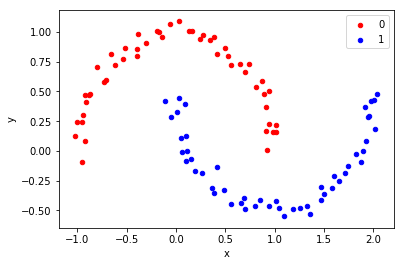

In [7]:
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y_raw))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [8]:
l1 = NeuronLayer(4,2)
l2 = NeuronLayer(3,4)
l3 = NeuronLayer(2,3)
fnn = NeuralNetwork([l1, l2, l3])

fnn.stochastic_gradient_descent(X_tr.values, y_tr.values, 0.01, 20000, 'sigmoid', 2, show_error=5000)

Epoch: 0
	Error:0.25329
Epoch: 5000
	Error:0.13792
Epoch: 10000
	Error:0.13776
Epoch: 15000
	Error:0.11878


In [9]:
predict_and_score(fnn, X_vl.values, y_vl)

0.95
